In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random

# The Target: Rightmove (Rentals in London)
# We start with a generic search URL for London
url = "https://www.rightmove.co.uk/property-to-rent/find.html?searchType=RENT&locationIdentifier=REGION%5E87490&index=0&includeLetAgreed=false"

# The Disguise: We must look like a Chrome browser, not a Python script
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# The Request
print("Attempting to contact Rightmove...")
response = requests.get(url, headers=headers)

# The Check
if response.status_code == 200:
    print("Success! We are in.")
    print("Data size:", len(response.text), "characters")
else:
    print("Blocked. Status Code:", response.status_code)

Attempting to contact Rightmove...
Success! We are in.
Data size: 1344427 characters


In [2]:
# Create the Soup (Parse the HTML)
soup = BeautifulSoup(response.text, "html.parser")

# 1. Find all Property Cards
# Rightmove usually calls these 'l-searchResult' or 'propertyCard'
property_cards = soup.find_all("div", class_="l-searchResult")

print(f"Found {len(property_cards)} properties on this page.")

# 2. Extract Data from each card
data = []

for card in property_cards:
    try:
        # Extract Price
        price_elem = card.find("span", class_="propertyCard-priceValue")
        price = price_elem.text.strip() if price_elem else "N/A"

        # Extract Address
        address_elem = card.find("address", class_="propertyCard-address")
        address = address_elem.text.strip() if address_elem else "N/A"

        # Extract Link (to the full listing)
        link_elem = card.find("a", class_="propertyCard-link")
        link = "https://www.rightmove.co.uk" + link_elem['href'] if link_elem else "N/A"

        # Only add valid listings (skip ads or empty cards)
        if price != "N/A":
            data.append({
                "Address": address,
                "Price": price,
                "Link": link
            })

    except Exception as e:
        continue # Skip if a card is broken

# 3. Save to a DataFrame (Table)
df = pd.DataFrame(data)

# Show the first 5 results
print("Success! Here is a preview of your data:")
print(df.head())

Found 0 properties on this page.
Success! Here is a preview of your data:
Empty DataFrame
Columns: []
Index: []


In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# 1. The Target: OpenRent (London)
url = "https://www.openrent.co.uk/properties-to-rent/london"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# 2. The Request
print(f"Scraping: {url}")
response = requests.get(url, headers=headers)

if response.status_code != 200:
    print(f"Blocked! Status: {response.status_code}")
else:
    soup = BeautifulSoup(response.text, "html.parser")

    # 3. The Extraction
    # OpenRent typically lists items in 'a' tags with specific classes or IDs
    # We will look for the main container that holds property info

    # Strategy: Find all links that look like property listings
    # OpenRent property links usually contain '/properties-to-rent/'
    cards = soup.find_all("a", href=True)

    data = []
    print(f"Scanning {len(cards)} elements...")

    for card in cards:
        # Filter: Only look at actual property listing cards
        # We look for a price symbol '£' inside the card text to confirm it's a listing
        if "/property-to-rent/" in card['href'] and "£" in card.text:

            try:
                # Extract Text (OpenRent often bundles text in the main link element)
                full_text = card.text.strip()

                # Simple extraction: Split text by lines to find Price and Address
                lines = [line.strip() for line in full_text.split('\n') if line.strip()]

                # Usually the Price is the first or last valid element
                # This is a 'heuristic' (educated guess) approach
                price = "N/A"
                address = "N/A"

                for line in lines:
                    if "£" in line and "pcm" in line:
                        price = line
                    elif len(line) > 10 and "£" not in line: # Assume long text without £ is address
                        address = line

                # Save if we found a price
                if price != "N/A":
                    data.append({
                        "Price": price,
                        "Address": address,
                        "Link": "https://www.openrent.co.uk" + card['href']
                    })
            except:
                continue

    # 4. Results
    if len(data) > 0:
        df = pd.DataFrame(data)
        # Drop duplicates because scrapers often grab the same link twice
        df = df.drop_duplicates()
        print(f"Success! Found {len(df)} properties.")
        print(df.head())
    else:
        print("Found 0 properties. They might have changed the HTML structure.")
        # Debugging: Print a bit of the HTML to see what's wrong
        print("Debug - HTML Preview:")
        print(soup.prettify()[:500])

Scraping: https://www.openrent.co.uk/properties-to-rent/london
Blocked! Status: 202


In [1]:
!pip install cloudscraper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 3.7 MB/s eta 0:00:00


In [2]:
import cloudscraper
from bs4 import BeautifulSoup
import pandas as pd

# 1. Create the Scraper
# This creates a session that solves the javascript challenges automatically
scraper = cloudscraper.create_scraper()

# 2. The Target: OpenRent London
url = "https://www.openrent.co.uk/properties-to-rent/london"

print(f"Attempting to breach: {url}")
response = scraper.get(url)

# 3. Check Access
if response.status_code == 200:
    print("Success! We bypassed the protection.")

    # 4. Extract Data
    soup = BeautifulSoup(response.text, "html.parser")

    # OpenRent lists usually live in 'a' tags. We look for the price symbol '£'.
    cards = soup.find_all("a", href=True)
    data = []

    print(f"Scanning {len(cards)} elements...")

    for card in cards:
        # Filter for property links
        if "/property-to-rent/" in card['href'] and "£" in card.text:
            try:
                # Basic Text Extraction
                full_text = card.text.strip()
                lines = [line.strip() for line in full_text.split('\n') if line.strip()]

                price = "N/A"
                address = "N/A"

                # Simple logic to separate Price from Address
                for line in lines:
                    if "£" in line and "pcm" in line:
                        price = line
                    elif len(line) > 10 and "£" not in line:
                        address = line

                if price != "N/A":
                    data.append({
                        "Price": price,
                        "Address": address,
                        "Link": "https://www.openrent.co.uk" + card['href']
                    })
            except:
                continue

    # 5. Show Results
    if len(data) > 0:
        df = pd.DataFrame(data).drop_duplicates()
        print(f"Success! Found {len(df)} properties.")
        print(df.head())
    else:
        print("Access granted, but found 0 properties. The HTML structure might be tricky.")

else:
    print(f"Still Blocked. Status Code: {response.status_code}")

Attempting to breach: https://www.openrent.co.uk/properties-to-rent/london
Success! We bypassed the protection.
Scanning 161 elements...
Access granted, but found 0 properties. The HTML structure might be tricky.


In [3]:
import cloudscraper
from bs4 import BeautifulSoup
import pandas as pd
import re

scraper = cloudscraper.create_scraper()
url = "https://www.openrent.co.uk/properties-to-rent/london"
response = scraper.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, "html.parser")

    # FIND EVERYTHING that looks like a rent price (e.g., £1,200pcm)
    # We use Regex (Regular Expressions) to hunt patterns, not tags.
    # Pattern: £ followed by numbers, maybe a comma, then pcm
    prices = soup.find_all(string=re.compile(r"£[\d,]+.*pcm"))

    print(f"Found {len(prices)} price tags.")

    data = []
    for p in prices:
        # The price is usually inside a container. Let's grab the parent container's text.
        parent = p.find_parent("div") or p.find_parent("a")

        if parent:
            # Clean up the text (remove extra spaces)
            clean_text = " | ".join(parent.get_text(separator="|").split())
            data.append(clean_text)

    if len(data) > 0:
        print("--- SAMPLE DATA FOUND ---")
        for i, item in enumerate(data[:5]): # Show first 5
            print(f"[{i}] {item}")
            print("-" * 50)
    else:
        print("Still nothing. The site might be using JavaScript to load data (Client-Side Rendering).")

Found 0 price tags.
Still nothing. The site might be using JavaScript to load data (Client-Side Rendering).


In [1]:
import pandas as pd
import io
import requests

# 1. The Source: UK Land Registry (Official Gov Data)
# We are grabbing the full 2024 dataset.
url = "http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2024.csv"

print("Downloading official Government Data (this may take 30 seconds)...")
response = requests.get(url)

# 2. Load into DataFrame
# The file has no headers, so we must define them manually based on Gov documentation.
columns = [
    "Transaction_ID", "Price", "Date_Transfer", "Postcode", "Property_Type",
    "Old_New", "Duration", "PAON", "SAON", "Street", "Locality", "Town_City",
    "District", "County", "PPD_Category_Type", "Record_Status"
]

print("Processing data...")
df = pd.read_csv(io.BytesIO(response.content), names=columns, header=None)

# 3. Filter for London
# We look for records where the 'District' or 'Town_City' is London-based.
# Note: 'LONDON' is usually in the Town_City column.
london_df = df[df['Town_City'] == 'LONDON'].copy()

# 4. Clean Data
# Convert Price to numeric and Date to datetime objects
london_df['Price'] = pd.to_numeric(london_df['Price'], errors='coerce')
london_df['Date_Transfer'] = pd.to_datetime(london_df['Date_Transfer'])

# 5. The "Money Shot"
print(f"SUCCESS. You now possess {len(london_df)} real estate transactions from 2024.")
print("Average House Price in London (2024): £{:,.0f}".format(london_df['Price'].mean()))
print("\nSample Data:")
print(london_df[['Date_Transfer', 'Postcode', 'Street', 'Price', 'Property_Type']].head())

Processing data...
SUCCESS. You now possess 63206 real estate transactions from 2024.
Average House Price in London (2024): £958,046

Sample Data:
    Date_Transfer Postcode              Street   Price Property_Type
132    2024-03-22  E13 9JF        WESTERN ROAD  339000             F
133    2024-10-11  N10 1HT     EVERINGTON ROAD  567500             T
137    2024-09-30  N17 7QE  TOWER GARDENS ROAD  474000             T
144    2024-07-03  N13 5HU      WAUTHIER CLOSE  500000             T
145    2024-07-11  E11 3QA         HARROW ROAD  520000             T


In [3]:
import pandas as pd
import io
import requests

# Ensure london_df is defined - copied from the preceding cell (nqf1zhxIeAC4) to make this cell self-contained
# 1. The Source: UK Land Registry (Official Gov Data)
url = "http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2024.csv"
response = requests.get(url)

# 2. Load into DataFrame
columns = [
    "Transaction_ID", "Price", "Date_Transfer", "Postcode", "Property_Type",
    "Old_New", "Duration", "PAON", "SAON", "Street", "Locality", "Town_City",
    "District", "County", "PPD_Category_Type", "Record_Status"
]
df = pd.read_csv(io.BytesIO(response.content), names=columns, header=None)

# 3. Filter for London
london_df = df[df['Town_City'] == 'LONDON'].copy()

# 4. Clean Data
london_df['Price'] = pd.to_numeric(london_df['Price'], errors='coerce')
london_df['Date_Transfer'] = pd.to_datetime(london_df['Date_Transfer'])

# Original content of cell g8k_wbRUk6g7 starts here
# 1. Postcode Analysis (Group by District)
# We extract the first part of the postcode (e.g., "SW1A" from "SW1A 1AA")
london_df['District_Code'] = london_df['Postcode'].str.split(' ').str[0]

# Calculate Average Price per District and Count transactions
district_stats = london_df.groupby('District_Code').agg({
    'Price': 'mean',
    'Transaction_ID': 'count'
}).rename(columns={'Price': 'Avg_Price', 'Transaction_ID': 'Sales_Volume'})

# Filter for areas with at least 50 sales (to remove outliers/noise)
robust_districts = district_stats[district_stats['Sales_Volume'] > 50].sort_values(by='Avg_Price', ascending=False)

# 2. Property Type Analysis
# D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other
type_map = {'D': 'Detached', 'S': 'Semi-Detached', 'T': 'Terraced', 'F': 'Flat', 'O': 'Other'}
london_df['Property_Label'] = london_df['Property_Type'].map(type_map)

type_stats = london_df.groupby('Property_Label')['Price'].mean().sort_values(ascending=False)

# --- THE REPORT ---
print("=== LONDON MARKET REPORT 2024 ===")
print(f"Total Sales Analyzed: {len(london_df)}")
print(f"Overall Average Price: £{london_df['Price'].mean():,.0f}\n")

print("--- TOP 5 MOST EXPENSIVE DISTRICTS ---")
print(robust_districts.head(5))

print("\n--- TOP 5 MOST AFFORDABLE DISTRICTS ---")
print(robust_districts.tail(5))

print("\n--- PRICE BY PROPERTY TYPE ---")
for p_type, price in type_stats.items():
    print(f"{p_type}: £{price:,.0f}")


=== LONDON MARKET REPORT 2024 ===
Total Sales Analyzed: 63206
Overall Average Price: £958,046

--- TOP 5 MOST EXPENSIVE DISTRICTS ---
                  Avg_Price  Sales_Volume
District_Code                            
W1J            8.334337e+06            63
W1K            5.833978e+06           100
SW1X           5.528409e+06           153
W1W            3.711303e+06            58
EC1M           3.329452e+06            66

--- TOP 5 MOST AFFORDABLE DISTRICTS ---
                   Avg_Price  Sales_Volume
District_Code                             
SE2            393824.319149           235
N9             390322.158854           384
SE25           376647.452026           469
E13            372236.710145           276
SE28           344552.779026           267

--- PRICE BY PROPERTY TYPE ---
Other: £3,109,786
Detached: £2,334,193
Semi-Detached: £1,186,882
Terraced: £1,034,480
Flat: £654,246


In [2]:
import pandas as pd
import io
import requests

# --- STEP 1: DOWNLOAD & LOAD ---
url = "http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2024.csv"
print("Downloading official Government Data (Wait 30 seconds)...")
response = requests.get(url)

columns = [
    "Transaction_ID", "Price", "Date_Transfer", "Postcode", "Property_Type",
    "Old_New", "Duration", "PAON", "SAON", "Street", "Locality", "Town_City",
    "District", "County", "PPD_Category_Type", "Record_Status"
]

# Load and Filter for London
df = pd.read_csv(io.BytesIO(response.content), names=columns, header=None)
london_df = df[df['Town_City'] == 'LONDON'].copy()
london_df['Price'] = pd.to_numeric(london_df['Price'], errors='coerce')

# --- STEP 2: ANALYZE ---
# Extract District Code (First half of postcode)
london_df['District_Code'] = london_df['Postcode'].str.split(' ').str[0]

# Group by District
district_stats = london_df.groupby('District_Code').agg({
    'Price': 'mean',
    'Transaction_ID': 'count'
}).rename(columns={'Price': 'Avg_Price', 'Transaction_ID': 'Sales_Volume'})

# Filter for robustness (>50 sales)
robust_districts = district_stats[district_stats['Sales_Volume'] > 50].sort_values(by='Avg_Price', ascending=False)

# Analyze Property Types
type_map = {'D': 'Detached', 'S': 'Semi-Detached', 'T': 'Terraced', 'F': 'Flat', 'O': 'Other'}
london_df['Property_Label'] = london_df['Property_Type'].map(type_map)
type_stats = london_df.groupby('Property_Label')['Price'].mean().sort_values(ascending=False)

# --- REPORT ---
print("\n=== LONDON MARKET REPORT 2024 ===")
print(f"Total Transactions: {len(london_df)}")
print("--- TOP 5 MOST EXPENSIVE DISTRICTS ---")
print(robust_districts.head(5))
print("\n--- TOP 5 CHEAPEST DISTRICTS ---")
print(robust_districts.tail(5))
print("\n--- PRICE BY PROPERTY TYPE ---")
print(type_stats)


=== LONDON MARKET REPORT 2024 ===
Total Transactions: 63206
--- TOP 5 MOST EXPENSIVE DISTRICTS ---
                  Avg_Price  Sales_Volume
District_Code                            
W1J            8.334337e+06            63
W1K            5.833978e+06           100
SW1X           5.528409e+06           153
W1W            3.711303e+06            58
EC1M           3.329452e+06            66

--- TOP 5 CHEAPEST DISTRICTS ---
                   Avg_Price  Sales_Volume
District_Code                             
SE2            393824.319149           235
N9             390322.158854           384
SE25           376647.452026           469
E13            372236.710145           276
SE28           344552.779026           267

--- PRICE BY PROPERTY TYPE ---
Property_Label
Other            3.109786e+06
Detached         2.334193e+06
Semi-Detached    1.186882e+06
Terraced         1.034480e+06
Flat             6.542457e+05
Name: Price, dtype: float64


/tmp/ipython-input-2160316584.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
/tmp/ipython-input-2160316584.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['£{:,.0f}M'.format(x/1000000) for x in current_values])


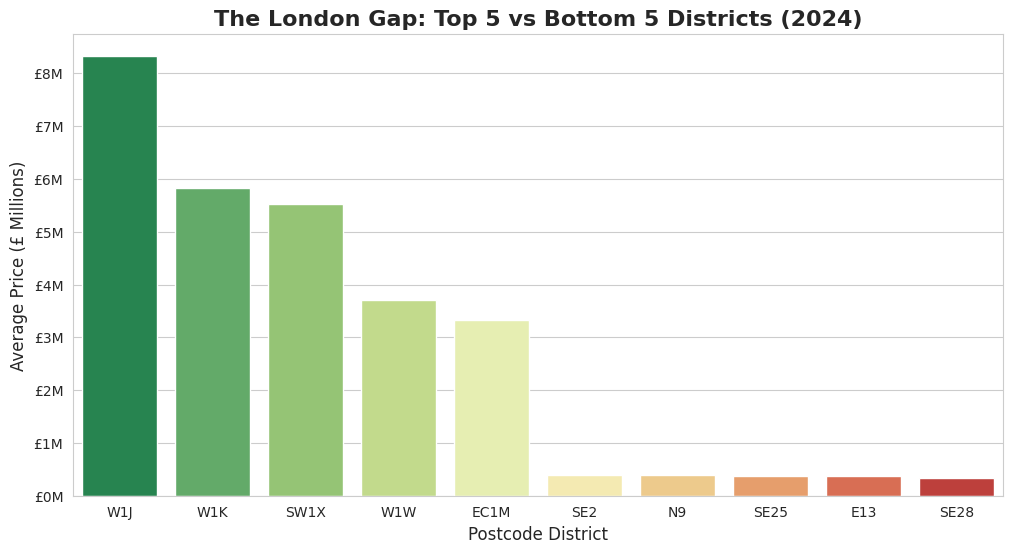

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare Data for Plotting
# Combine Top 5 and Bottom 5 for a dramatic contrast
top_5 = robust_districts.head(5).reset_index()
bottom_5 = robust_districts.tail(5).reset_index()
plot_data = pd.concat([top_5, bottom_5])

# 2. The Plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create Bar Chart
# We use a color palette where Expensive = Red, Cheap = Green
barplot = sns.barplot(
    data=plot_data,
    x='District_Code',
    y='Avg_Price',
    palette='RdYlGn_r' # Red to Green reversed
)

# 3. Polish the Aesthetics
plt.title('The London Gap: Top 5 vs Bottom 5 Districts (2024)', fontsize=16, fontweight='bold')
plt.xlabel('Postcode District', fontsize=12)
plt.ylabel('Average Price (£ Millions)', fontsize=12)

# Format Y-axis to show "£8M" instead of scientific notation
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['£{:,.0f}M'.format(x/1000000) for x in current_values])

plt.show()